##Imports

In [1]:
!git clone https://github.com/ReportBmunoz/HistoXpaining-in-Style.git

Cloning into 'HistoXpaining-in-Style'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 1), reused 29 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 14.53 MiB | 9.16 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122

Looking in indexes: https://download.pytorch.org/whl/cu122


In [3]:
!apt-get install ninja-build
!pip install lmdb tqdm wandb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 3s (42.5 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 23.8 MB/s eta 0:00:00


In [4]:
!pip install umap-learn matplotlib

In [5]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [6]:
!git clone https://github.com/S-aiueo32/lpips-pytorch.git

Cloning into 'lpips-pytorch'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 107 (delta 46), reused 73 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 576.88 KiB | 2.33 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [7]:
import torch
print(torch.cuda.is_available())

True


In [8]:
import sys
sys.path.append('/content/HistoXpaining-in-Style/code')

In [9]:
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "6.0;7.0;7.5;8.0;8.6"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import torch
import torch.nn.functional as F
from dataset import MultiResolutionDataset
from torchvision import transforms, models, utils
from model import Generator, Encoder
import argparse
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
from io import BytesIO
from torch.utils.data import DataLoader
from torchvision import utils
import requests
import att_find_code.att_find_functions as att_find_func

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Pruebas

In [21]:
import numpy as np
import torch
from model import Generator
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score
torch.cuda.empty_cache()

# Configuración adicional para manejar el modelo condicional
# Init config to manage conditional model
class Args:
    def __init__(self):
        self.size = 256
        self.latent = 512
        self.n_mlp = 8
        self.channel_multiplier = 2
        self.ckpt = "/content/drive/MyDrive/HistoXplaining in Style/Models/Stylegan2-ada/064000_16-3f.pt"
        self.classifier_ckpt = "/content/drive/MyDrive/HistoXplaining in Style/Models/Classifiers/model_colon.pth"
        self.device = "cuda"
        self.n_samples = 200
        self.batch_size = 8
        self.cgan = True  # Conditional
        self.classifier_nof_classes = 2
        self.embedding_size = 10

args = Args()

def load_classifier():
    classifier = models.densenet121(pretrained=True)
    classifier.classifier = torch.nn.Linear(1024, 2)
    classifier.load_state_dict(torch.load(args.classifier_ckpt))
    classifier.to("cpu")
    classifier.eval()
    return classifier

# Load pretrained model
def load_generator(args):

    checkpoint = torch.load(args.ckpt, weights_only=False)
    params = checkpoint["args"]

    generator = Generator(params.size, params.latent, params.n_mlp,
                        channel_multiplier=params.channel_multiplier,
                        conditional_gan=params.cgan if 'cgan' in params else False,
                        nof_classes=params.classifier_nof_classes if 'classifier_nof_classes' in params else False,
                        embedding_size=params.embedding_size).to('cuda')

    generator.load_state_dict(checkpoint['g_ema'])
    generator.eval()
    return generator

generator = load_generator(args)
classifier = load_classifier()

def get_latent_vectors_and_labels(generator, args):
    latents = []
    styles = []
    labels = []

    with torch.no_grad():
        # z = torch.randn(args.batch_size, args.latent, device=args.device)
        # w = generator.style(z)

        for _ in range(args.n_samples // args.batch_size):
            z = torch.randn(args.batch_size, args.latent, device=args.device)

            # Generar etiquetas aleatorias binarias
            batch_labels = torch.randint(0, 2, (args.batch_size,)).to(args.device)
            one_hot_labels = F.one_hot(batch_labels, num_classes=2).float()

            # Generar estilos con etiquetas
            w = generator.style(z)

            # Para modelos condicionales, concatenar embeddings de etiquetas
            # if args.cgan:
            #     label_emb = generator.embedding(batch_labels)
            #     w = torch.cat([w, label_emb], dim=1)

            latents.append(z.cpu().numpy())
            styles.append(w.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())

    return (np.concatenate(latents),
            np.concatenate(styles),
            np.concatenate(labels))

# Generar vectores y etiquetas
# z_vectors, w_vectors, true_labels = get_latent_vectors_and_labels(generator, encoder, args)
z_vectors, w_vectors, true_labels = get_latent_vectors_and_labels(generator, args)

# Función para obtener predicciones del clasificador
def get_class_predictions(images):
    images = images.to("cpu")

    with torch.no_grad():
        classifier.to("cpu")
        features = classifier(images)
    return torch.argmax(features, dim=1).cpu().numpy()

def get_class_probs(images):
    images = images.to("cpu")
    img_normalized = (images - images.min()) / (images.max() - images.min())  # Normalizar imagen
    img_normalized = img_normalized.cpu()

    with torch.no_grad():
        classifier.to("cpu")
        logits = classifier(img_normalized)  # Now both input and model are on same device
        prob = torch.sigmoid(logits.squeeze(0))
    return prob.cpu().numpy()

def generate_sample_images_in_chunks(generator, vectors, labels, noise, chunk_size=32):
# def generate_sample_images_in_chunks(generator, vectors, labels, chunk_size=32):
    images = []
    for i in range(0, len(vectors), chunk_size):
        batch_z = torch.tensor(vectors[i:i+chunk_size], device=args.device).float()
        batch_labels = torch.tensor(labels[i:i+chunk_size], device=args.device)

        with torch.no_grad():
            generated, _ = generator([batch_z], labels=batch_labels, noise=noise)
            # generated, _ = generator([batch_z], labels=batch_labels)
            images.append(generated.cpu())

        torch.cuda.empty_cache()  # Free GPU memory after each chunk

    return torch.cat(images)

noise = [torch.randn(1, 1, 2**2, 2**2, device=args.device)]  # Ruido para la resolución base
for i in range(3, generator.log_size + 1):
    for _ in range(2):
        noise.append(torch.randn(1, 1, 2**i, 2**i, device=args.device))

# Generar imágenes y obtener predicciones
sample_images = generate_sample_images_in_chunks(generator, w_vectors, true_labels, noise)
# sample_images = generate_sample_images_in_chunks(generator, w_vectors, true_labels)
torch.cuda.empty_cache()
predicted_labels = get_class_predictions(sample_images)
prob_labels = get_class_probs(sample_images)
torch.cuda.empty_cache()

# Reducción UMAP con información de clases
reducer = umap.UMAP(n_components=2, random_state=42)
w_reduced = reducer.fit_transform(w_vectors.reshape(w_vectors.shape[0], -1))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [49]:
import numpy as np
import torch
from model import Generator
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score
torch.cuda.empty_cache()

# Additional configuration to handle conditional model
class Args:
    def __init__(self):
        self.size = 256
        self.latent = 512
        self.n_mlp = 8
        self.channel_multiplier = 2
        self.ckpt = "/content/drive/MyDrive/HistoXplaining in Style/Models/Stylegan2-ada/064000_16-3f.pt"
        self.classifier_ckpt = "/content/drive/MyDrive/HistoXplaining in Style/Models/Classifiers/model_colon.pth"
        self.device = "cuda"
        self.n_samples = 200
        self.batch_size = 8
        self.cgan = True  # Conditional
        self.classifier_nof_classes = 2
        self.embedding_size = 10

args = Args()

def load_classifier():
    classifier = models.densenet121(pretrained=True)
    classifier.classifier = torch.nn.Linear(1024, 2)
    classifier.load_state_dict(torch.load(args.classifier_ckpt))
    classifier.to("cpu")
    classifier.eval()
    return classifier

# Load pretrained model
def load_generator(args):

    checkpoint = torch.load(args.ckpt, weights_only=False)
    params = checkpoint["args"]

    generator = Generator(params.size, params.latent, params.n_mlp,
                        channel_multiplier=params.channel_multiplier,
                        conditional_gan=params.cgan if 'cgan' in params else False,
                        nof_classes=params.classifier_nof_classes if 'classifier_nof_classes' in params else False,
                        embedding_size=params.embedding_size).to('cuda')

    generator.load_state_dict(checkpoint['g_ema'])
    generator.eval()
    return generator

generator = load_generator(args)
classifier = load_classifier()

def get_latent_vectors_and_labels(generator, args):
    latents = []
    styles = []
    labels = []

    with torch.no_grad():
        # z = torch.randn(args.batch_size, args.latent, device=args.device)
        # w = generator.style(z)

        for _ in range(args.n_samples // args.batch_size):
            z = torch.randn(args.batch_size, args.latent, device=args.device)

            # Generate random binary labels
            batch_labels = torch.randint(0, 2, (args.batch_size,)).to(args.device)
            one_hot_labels = F.one_hot(batch_labels, num_classes=2).float()

            # Generate styles with labels
            w = generator.style(z)

            # For conditional models, concatenate label embeddings
            # if args.cgan:
            #     label_emb = generator.embedding(batch_labels)
            #     w = torch.cat([w, label_emb], dim=1)

            latents.append(z.cpu().numpy())
            styles.append(w.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())

    return (np.concatenate(latents),
            np.concatenate(styles),
            np.concatenate(labels))

# Generate vectors and labels
# z_vectors, w_vectors, true_labels = get_latent_vectors_and_labels(generator, encoder, args)
z_vectors, w_vectors, true_labels = get_latent_vectors_and_labels(generator, args)

# Function to get classifier predictions
def get_class_predictions(images):
    images = images.to("cpu")

    with torch.no_grad():
        classifier.to("cpu")
        features = classifier(images)
    return torch.argmax(features, dim=1).cpu().numpy()

def get_class_probs(images):
    images = images.to("cpu")
    img_normalized = (images - images.min()) / (images.max() - images.min())  # Normalize image
    img_normalized = img_normalized.cpu()

    with torch.no_grad():
        classifier.to("cpu")
        logits = classifier(img_normalized)  # Now both input and model are on same device
        prob = torch.sigmoid(logits.squeeze(0))
    return prob.cpu().numpy()

def generate_sample_images_in_chunks(generator, vectors, labels, noise, chunk_size=32):
# def generate_sample_images_in_chunks(generator, vectors, labels, chunk_size=32):
    images = []
    for i in range(0, len(vectors), chunk_size):
        batch_z = torch.tensor(vectors[i:i+chunk_size], device=args.device).float()
        batch_labels = torch.tensor(labels[i:i+chunk_size], device=args.device)

        with torch.no_grad():
            generated, _ = generator([batch_z], labels=batch_labels, noise=noise)
            # generated, _ = generator([batch_z], labels=batch_labels)
            images.append(generated.cpu())

        torch.cuda.empty_cache()  # Free GPU memory after each chunk

    return torch.cat(images)

noise = [torch.randn(1, 1, 2**2, 2**2, device=args.device)]  # Noise for base resolution
for i in range(3, generator.log_size + 1):
    for _ in range(2):
        noise.append(torch.randn(1, 1, 2**i, 2**i, device=args.device))

# Generate images and get predictions
sample_images = generate_sample_images_in_chunks(generator, w_vectors, true_labels, noise)
# sample_images = generate_sample_images_in_chunks(generator, w_vectors, true_labels)
torch.cuda.empty_cache()
predicted_labels = get_class_predictions(sample_images)
prob_labels = get_class_probs(sample_images)
torch.cuda.empty_cache()

# UMAP reduction with class information
reducer = umap.UMAP(n_components=2, random_state=42)
w_reduced = reducer.fit_transform(w_vectors.reshape(w_vectors.shape[0], -1))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipython-input-3066297514.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


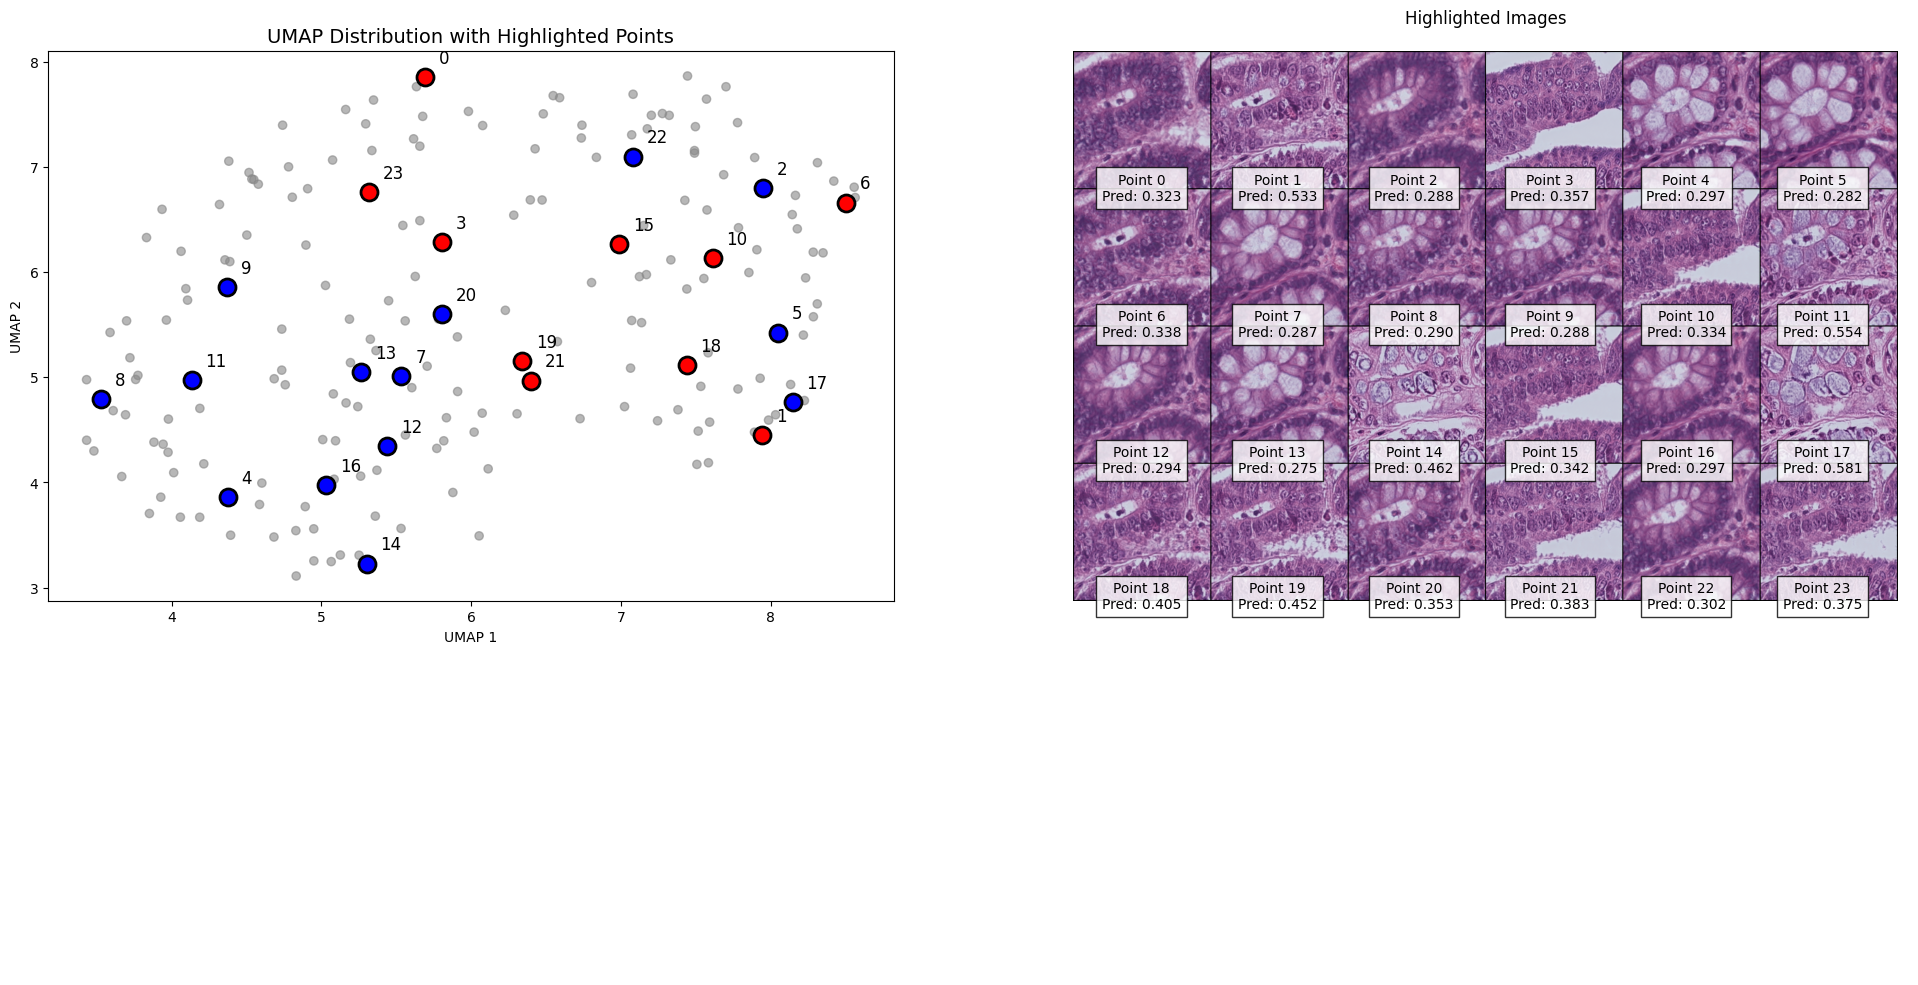

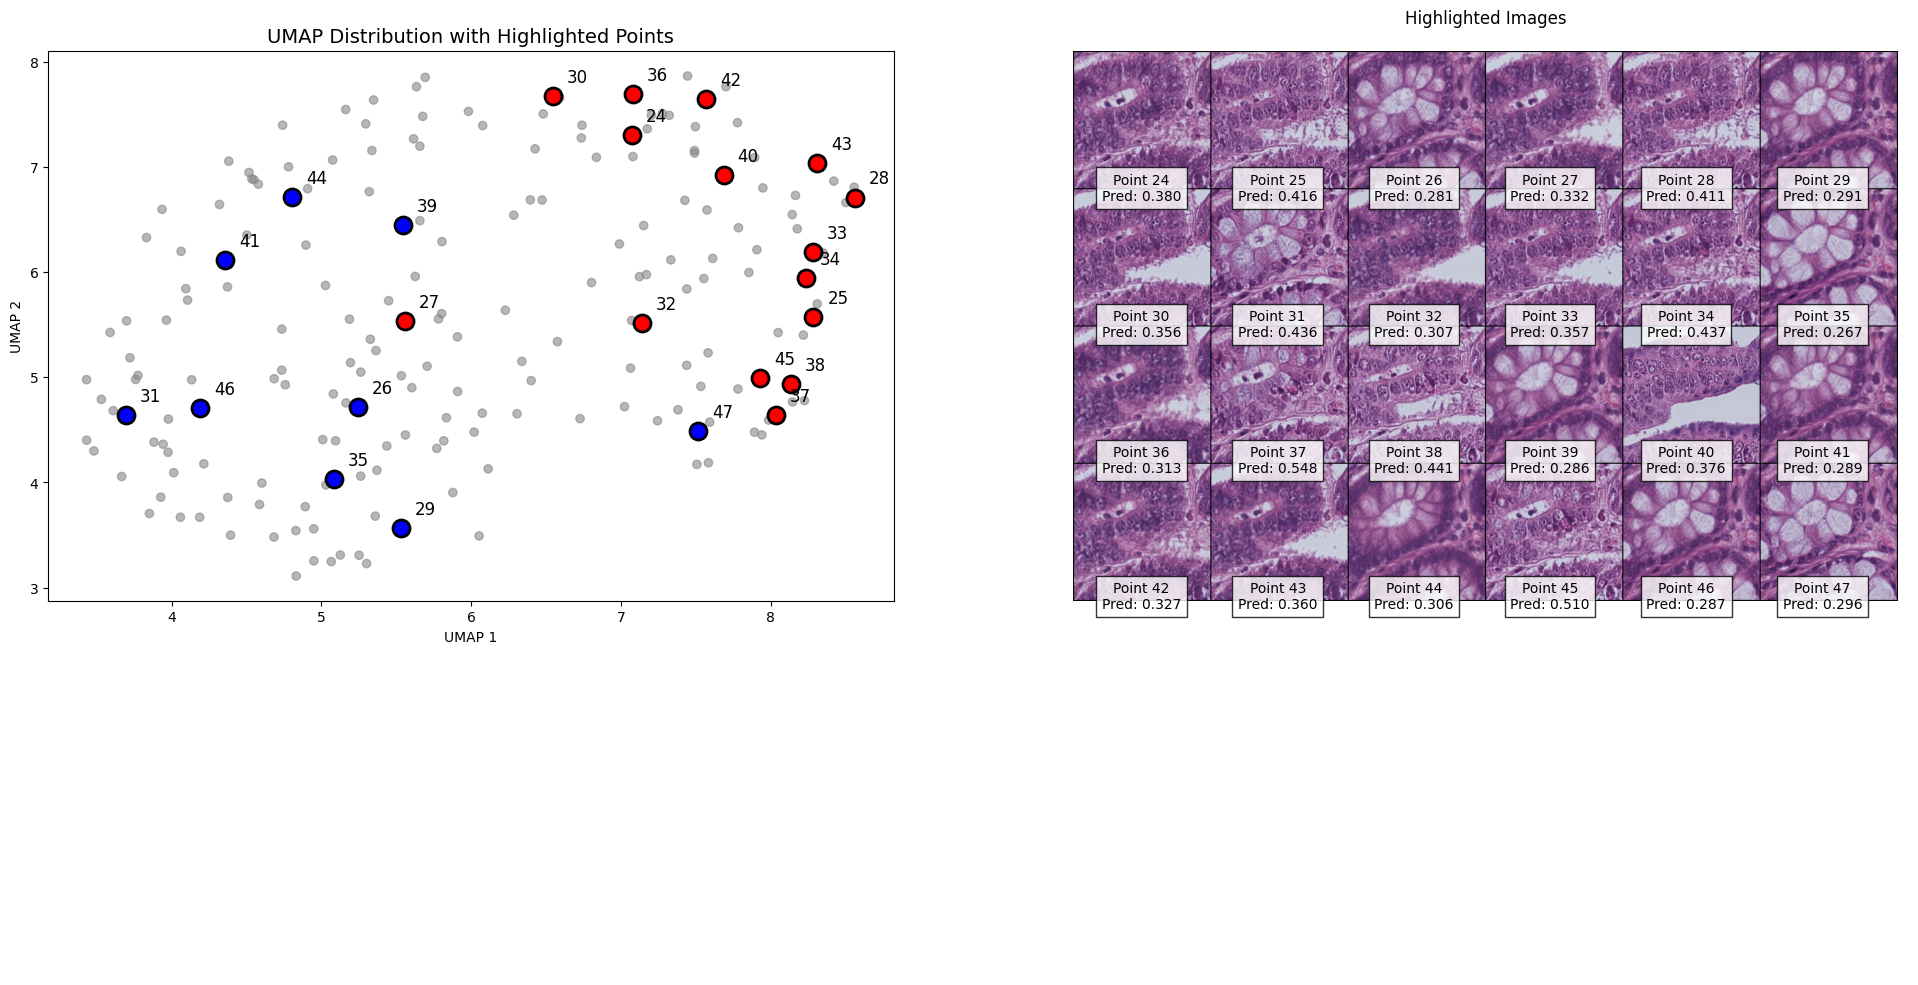

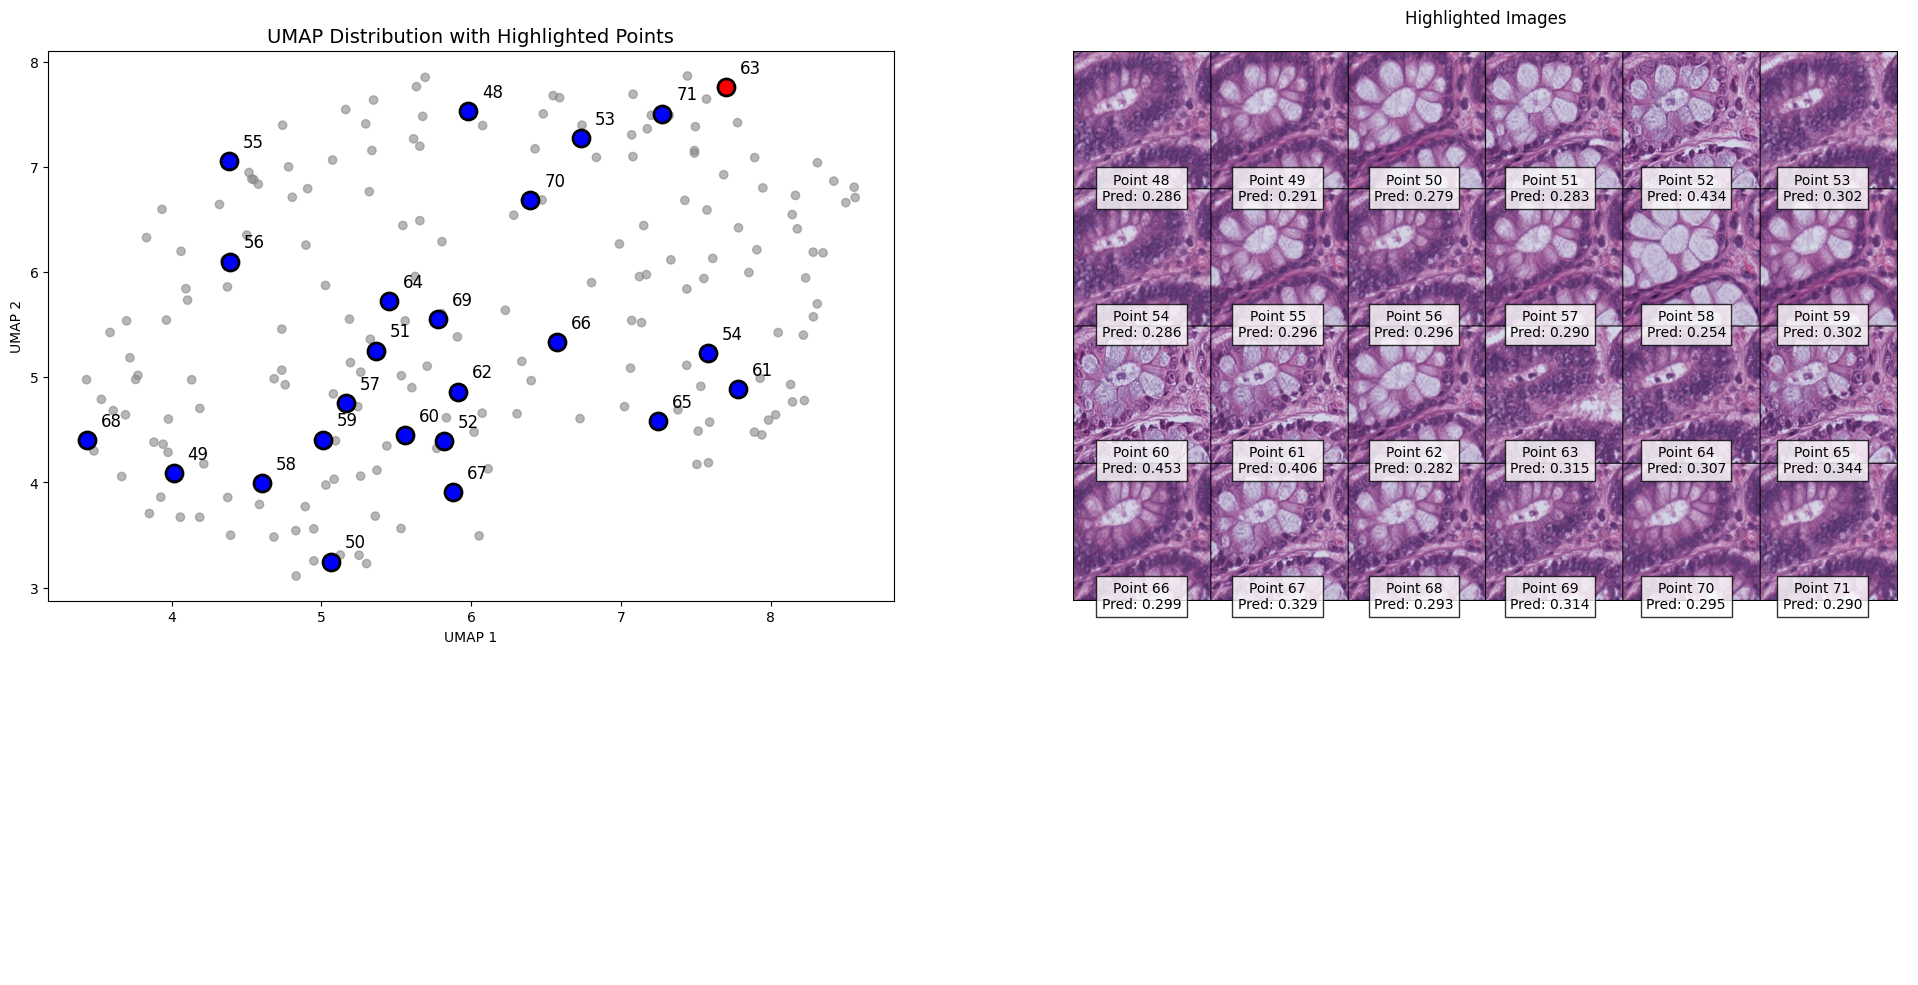

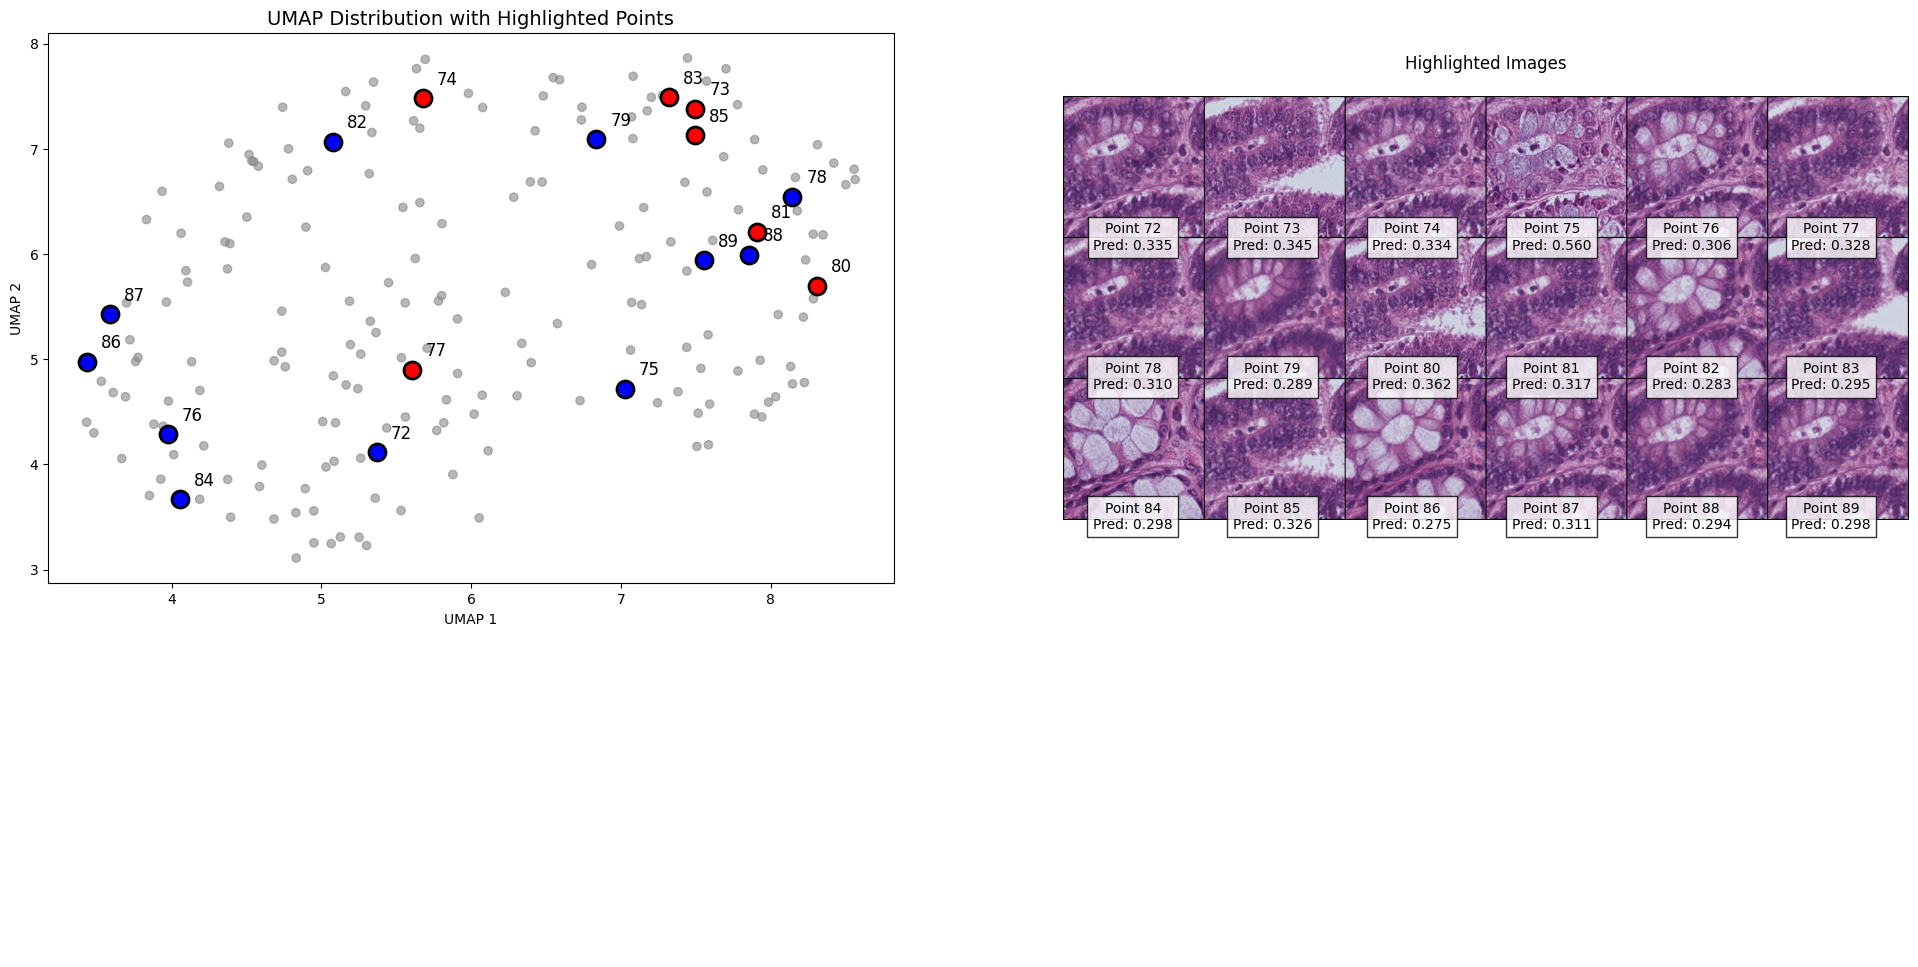

In [50]:
def highlight_points(reduced, true_labels, prob_labels, predicted_labels, sample_images, point_indices=[76, 102, 536, 95, 49, 617, 15, 332, 327, 1, 482, 300, 652]):
    fig = plt.figure(figsize=(24, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.4], width_ratios=[1, 1], hspace=0.4)

    # 1. UMAP plot with highlighted points
    ax1 = fig.add_subplot(gs[0, 0])

    # Create color array: gray for all except selected points
    colors = np.full(len(reduced), '#888888')  # Gray by default

    highlight_colors = ['blue' if predicted_labels[idx] == 0 else 'red' for idx in point_indices]

    for i, idx in enumerate(point_indices):
        colors[idx] = highlight_colors[i]

    # Plot all points
    scatter = ax1.scatter(reduced[:, 0], reduced[:, 1], c=colors, alpha=0.6)

    # Highlight and number specific points
    for i, idx in enumerate(point_indices):
        x, y = reduced[idx]
        ax1.scatter(x, y, c=highlight_colors[i], edgecolor='black', s=150, linewidth=2)
        ax1.annotate(f'{idx}', (x, y),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=12)
                    # arrowprops=dict(arrowstyle="->", color='black'))

    ax1.set_title('UMAP Distribution with Highlighted Points', fontsize=14)
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')

    # 2. Show images of highlighted points
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')

    # Get images and predictions
    highlight_images = [sample_images[i] for i in point_indices]
    highlight_preds = [prob_labels[i][1] for i in point_indices]
    highlight_true_labels = [true_labels[i] for i in point_indices]

    # Create image grid
    n_images = len(point_indices)
    n_cols = min(6, n_images)  # Maximum 6 columns
    n_rows = (n_images + n_cols - 1) // n_cols  # Calculate needed rows

    grid = make_grid(highlight_images, nrow=n_cols, normalize=True)
    grid = grid.permute(1, 2, 0).numpy()

    # Show images with annotations
    ax2.imshow(grid)
    ax2.set_title('Highlighted Images', fontsize=12, pad=20)

    # Add prediction labels
    for i, (img_idx, pred, true_label) in enumerate(zip(point_indices, highlight_preds, highlight_true_labels)):
        row = i // n_cols
        col = i % n_cols
        ax2.text(col * 256 + 128, row * 256 + 280,
                f'Point {img_idx}\nPred: {pred:.3f}',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8),
                ha='center')

    ax3 = fig.add_subplot(gs[1, :])
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

printear=[]
for i in range(90):
  printear.append(i)

highlight_points(w_reduced, true_labels, prob_labels, predicted_labels, sample_images, point_indices=printear[0:24])
highlight_points(w_reduced, true_labels, prob_labels, predicted_labels, sample_images, point_indices=printear[24:48])
highlight_points(w_reduced, true_labels, prob_labels, predicted_labels, sample_images, point_indices=printear[48:72])
highlight_points(w_reduced, true_labels, prob_labels, predicted_labels, sample_images, point_indices=printear[72:98])

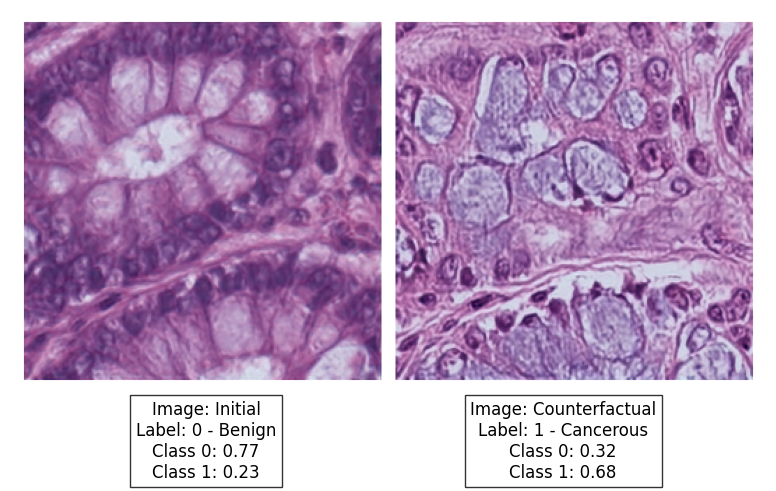

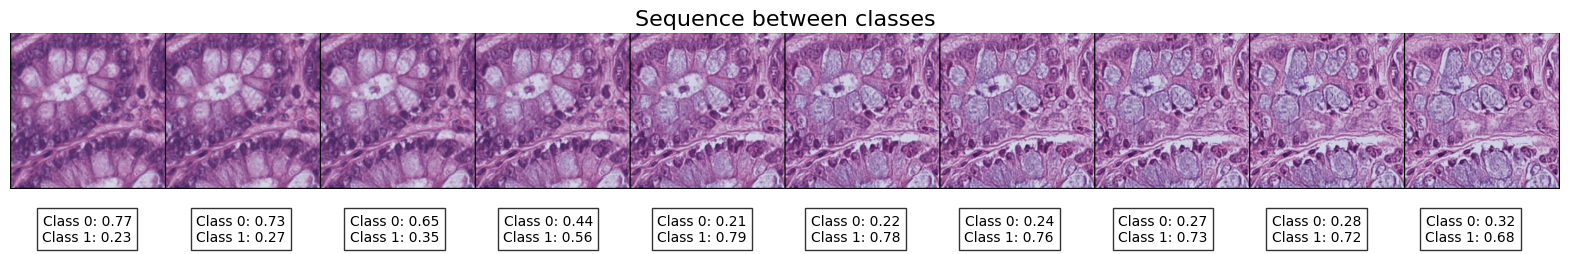

In [67]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Function to show interpolation with scoring
def plot_interpolation_with_scoring(images, probabilities, n_steps=10):
    """
    Shows interpolated images in a grid with their probabilities.

    Args:
        images (torch.Tensor): Tensor of interpolated images (shape: [n_steps, 3, H, W]).
        probabilities (torch.Tensor): Tensor of probabilities (shape: [n_steps, 2]).
        n_steps (int): Number of interpolation steps.
    """
    # Create a grid with the images
    grid = make_grid(images, nrow=n_steps, normalize=True)

    # Show the grid
    plt.figure(figsize=(20, 6))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')

    # Add text with probabilities
    for i in range(n_steps):
        prob_class_0 = probabilities[i, 0].item()  # Probability of class 0
        prob_class_1 = probabilities[i, 1].item()  # Probability of class 1
        plt.text(
            i * 256 + 128, 300,  # Text position
            f'Class 0: {prob_class_0:.2f}\nClass 1: {prob_class_1:.2f}',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8),
            ha='center',va='top'
        )
    plt.title(f'Sequence between classes', fontsize=16)
    plt.show()

def interpolate_images(generator, classifier, w1, w2, n_steps=10):
    """
    Interpolates between two latent W vectors from the original space (512D).

    Args:
        generator: StyleGAN generator model.
        classifier: Classifier model to obtain probabilities.
        w1 (torch.Tensor): First latent vector (shape: [1, 512]).
        w2 (torch.Tensor): Second latent vector (shape: [1, 512]).
        n_steps (int): Number of interpolation steps.
    """
    # Ensure vectors are on the correct device
    w1 = w1.to(args.device)
    w2 = w2.to(args.device)

    label_0 = torch.tensor([0], device=args.device)
    label_1 = torch.tensor([1], device=args.device)

    # Linear interpolation
    alpha = torch.linspace(0, 1, n_steps, device=args.device).view(-1, 1, 1)
    interpolated_w = (1 - alpha) * w1 + alpha * w2

    # Generate images and get probabilities
    with torch.no_grad():
        images = []
        probabilities = []
        i = 0
        for w in interpolated_w:
            # Generate image
            if i < n_steps // 2:
                img, _ = generator([w], labels=label_0, input_is_latent=True, noise=noise)
                # img, _ = generator([w], labels=label_0, input_is_latent=True)
            else:
                img, _ = generator([w], labels=label_1, input_is_latent=True, noise=noise)
            i += 1

            # Get classifier probabilities
            img_normalized = (img - img.min()) / (img.max() - img.min())  # Normalize image
            img_normalized = img_normalized.cpu()
            logits = classifier(img_normalized)
            prob = torch.softmax(logits, dim=1)  # Probabilities for both classes
            probabilities.append(prob.cpu())

            images.append(img.cpu())

    return torch.cat(images), torch.cat(probabilities)

def plot_extreme_images_with_labels(images, probabilities, labels):
    """
    Shows the extreme images from interpolation with their labels and probabilities.

    Args:
        images (torch.Tensor): Tensor of interpolated images (shape: [n_steps, 3, H, W]).
        probabilities (torch.Tensor): Tensor of probabilities (shape: [n_steps, 2]).
        labels (list): List of labels for the extreme images.
    """
    # Select extreme images (first and last)
    img_start = images[0]
    img_end = images[-1]

    # Select extreme probabilities
    prob_start = probabilities[0]
    prob_end = probabilities[-1]

    # Create a grid with both images
    grid = make_grid([img_start, img_end], nrow=2, normalize=True, padding=10, pad_value=1)

    # Show the grid
    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')

    # Add text with labels and probabilities
    for i, (img, prob, label) in enumerate(zip([img_start, img_end], [prob_start, prob_end], labels)):
      if prob[0] > 0.5:
        text = 'Benign'
        text2 = 'Initial'
        label = 0
      else:
        text = 'Cancerous'
        text2 = 'Counterfactual'
        label = 1
      plt.text(
          i * 256 + 140, 280,  # Text position
          f'Image: {text2}\nLabel: {label} - {text}\nClass 0: {prob[0]:.2f}\nClass 1: {prob[1]:.2f}',
          fontsize=12,
          bbox=dict(facecolor='white', alpha=0.8),
          ha='center', va='top'
      )

    plt.show()

# Get latent vectors from highlighted points
w1 = torch.tensor(w_vectors[41], device=args.device).unsqueeze(0)
w2 = torch.tensor(w_vectors[1], device=args.device).unsqueeze(0)

# Interpolate between the two points
interpolated_images, interpolated_probs = interpolate_images(generator, classifier, w1, w2, n_steps=10)

# Show extreme images with labels and probabilities
plot_extreme_images_with_labels(interpolated_images, interpolated_probs, labels=[0, 1])
plot_interpolation_with_scoring(interpolated_images, interpolated_probs, n_steps=10)

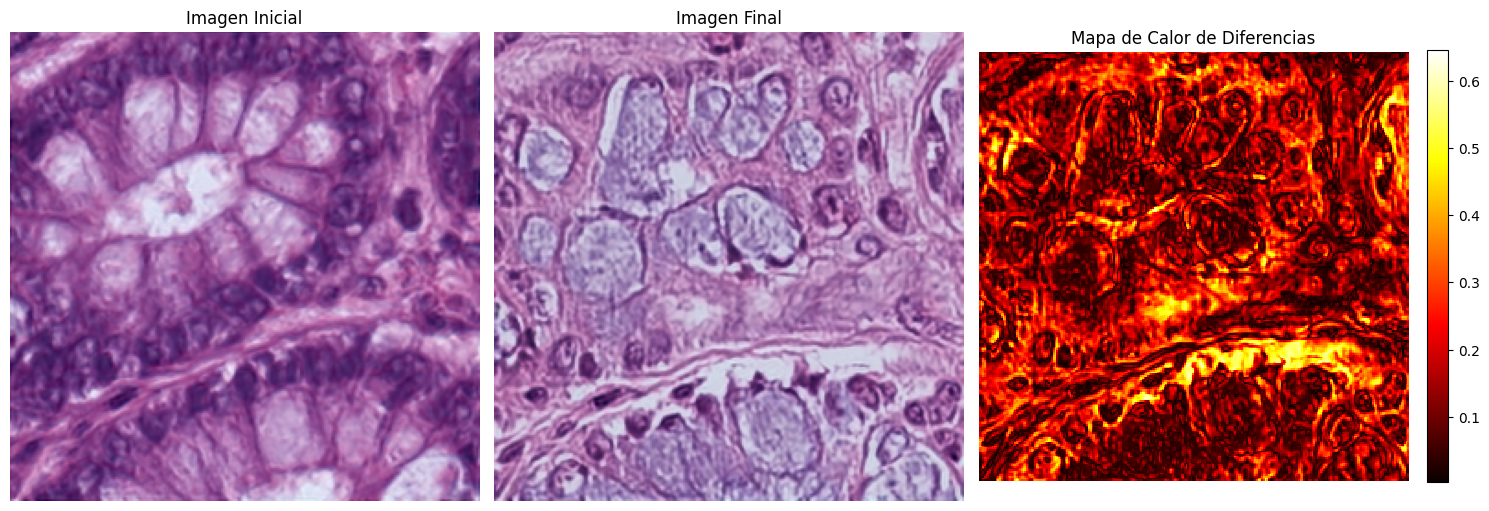

In [68]:
def plot_heatmap_difference(image_start, image_end):
    """
    Visualiza la diferencia entre dos imágenes como un mapa de calor.
    Args:
        image_start (torch.Tensor): Primera imagen (extremo inicial).
        image_end (torch.Tensor): Segunda imagen (extremo final).
    """
    # Normalizar las imágenes
    image_start = (image_start - image_start.min()) / (image_start.max() - image_start.min())
    image_end = (image_end - image_end.min()) / (image_end.max() - image_end.min())

    # Convertir las imágenes a numpy arrays
    img_start_np = image_start.squeeze().permute(1, 2, 0).numpy()
    img_end_np = image_end.squeeze().permute(1, 2, 0).numpy()

    # Calcular la diferencia absoluta entre las imágenes
    diff = np.abs(img_start_np - img_end_np)

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    # Mostrar la primera imagen
    axes[0].imshow(img_start_np)
    axes[0].set_title("Imagen Inicial", fontsize=12)
    axes[0].axis('off')

    # Mostrar la segunda imagen
    axes[1].imshow(img_end_np)
    axes[1].set_title("Imagen Final", fontsize=12)
    axes[1].axis('off')

    # Mostrar el mapa de calor de la diferencia
    heatmap = axes[2].imshow(
        diff.mean(axis=-1),
        cmap='hot',
        interpolation='nearest',
        extent=[0, img_start_np.shape[1], img_start_np.shape[0], 0]  # Ajustar tamaño
    )
    axes[2].set_title("Mapa de Calor de Diferencias", fontsize=12)
    axes[2].axis('off')

    # Añadir colorbar ajustada al tamaño de la figura
    cbar = fig.colorbar(heatmap, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_heatmap_difference(interpolated_images[0], interpolated_images[-1])